# **EXPLORATORY DATA ANALYSIS (EDA) OF THE DATASET**

## Import Libraries

In [ ]:
%%capture
!pip install pymorphy2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
import random
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import json
from pymorphy2 import MorphAnalyzer
import pymorphy2
from nltk.tokenize import word_tokenize

In [ ]:
%%capture
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 607 µs (started: 2024-06-21 13:43:15 +00:00)


## Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 12.8 s (started: 2024-06-21 13:43:15 +00:00)


In [ ]:
%cd "/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/__seminary_practice"

/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/__seminary_practice
time: 958 ms (started: 2024-06-21 13:43:28 +00:00)


## Load Stop Words in English and Russian

"Stop words" are a set of commonly used words in the English language. Examples of stop words in English include "a," "the," "is," "are," and so on. These words are ubiquitous and occur frequently in text but contribute very little to the overall meaning. In Text Mining and Natural Language Processing (NLP), stop words are often eliminated from text data to improve the efficiency and accuracy of analysis. By removing stop words, we can focus on the more informative content of the text and reduce noise in our analysis.

In [ ]:
morph = MorphAnalyzer()
stop_words_ru = set()
with open('stopwords-ru.txt', 'r', encoding='utf-8') as f:
    for word in f.readlines():
        stop_words_ru.add(morph.parse(word.strip())[0].normal_form)

time: 1.39 s (started: 2024-06-21 13:43:29 +00:00)


In [ ]:
len(stop_words_ru)

386

time: 6.95 ms (started: 2024-06-21 13:43:30 +00:00)


In [ ]:
ru_stop_words = pd.read_csv('stopwords-ru.txt',header=None)

time: 19.6 ms (started: 2024-06-21 13:43:30 +00:00)


In [ ]:
len(ru_stop_words)

559

time: 13.5 ms (started: 2024-06-21 13:43:30 +00:00)


We will use ``ru_stop_words``

## Load the Dataset

In [ ]:
file_path_without_lab = 'sums_lang_for_news.xlsx'
file_path_with_labels = 'augmented_full_sentiment_16_x.xlsx'
file_path_complete = 'страны_партнеры_с_тональностью_общий_271123.xlsx'

df_unlabelled = pd.read_excel(file_path_without_lab)
df_labelled = pd.read_excel(file_path_with_labels, usecols=lambda x: x != 'Unnamed: 9')
df = pd.read_excel(file_path_complete, usecols=lambda x: x != 'Unnamed: 9')

time: 6.08 s (started: 2024-06-21 13:43:30 +00:00)


In [ ]:
# Dictionary mapping Russian column names to English column names
column_rename_dict = {
    'Тип отношений': 'Relationship Type',
    'Коды МСТК': 'MSTK Codes',
    'Страны': 'Countries',
    'Событие': 'text',
    'Источник': 'Source',
    'Дата': 'Date',
    'Тональность': 'sentiment'
}

df_labelled.rename(columns=column_rename_dict, inplace=True)

time: 1.99 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_labelled.head()

,Unnamed: 0,text,label
0,0,США в очередной раз ужесточили правила экспорт...,2
1,1,"Санкции, введенные против России, такие как ис...",2
2,2,Посол Бразилии в Организации Объединенных Наци...,2
3,3,Беспрецедентные санкции против российских банк...,2
4,4,Государственная энергетическая компания Индоне...,0


time: 114 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
sentiment_mapping = {0: 'positive', 1: 'neutral', 2: 'negative'}

df_labelled['sentiment'] = df_labelled['label'].replace(sentiment_mapping)

df_labelled.head()

,Unnamed: 0,text,label,sentiment
0,0,США в очередной раз ужесточили правила экспорт...,2,negative
1,1,"Санкции, введенные против России, такие как ис...",2,negative
2,2,Посол Бразилии в Организации Объединенных Наци...,2,negative
3,3,Беспрецедентные санкции против российских банк...,2,negative
4,4,Государственная энергетическая компания Индоне...,0,positive


time: 88.3 ms (started: 2024-06-21 13:43:37 +00:00)


We need text classification for titles and for news texts.

In [ ]:
df_titles = df[['title', 'sentiment']]
df_text = df_labelled[['text', 'sentiment']]

time: 9 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_val = df_titles.copy()

time: 748 µs (started: 2024-06-21 13:43:37 +00:00)


## Explore the Basic Properties of the Dataset

### Shape of the dataset

In [ ]:
print(f"Shape of texts (rows, cols)=> {df_text.shape}")
print(f"Shape of titles (rows, cols)=> {df_titles.shape}")

Shape of texts (rows, cols)=> (9835, 2)
Shape of titles (rows, cols)=> (486, 2)
time: 811 µs (started: 2024-06-21 13:43:37 +00:00)


### Check the duplicates


In [ ]:
df_text.describe(include='all')

,text,sentiment
count,9835,9835
unique,6935,3
top,Американский производитель спортивной одежды N...,positive
freq,9,3694


time: 44.6 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_titles.describe(include='all')

,title,sentiment
count,486,486
unique,484,3
top,Экспорт российского мороженого в 2022 году упа...,negative
freq,2,291


time: 26.4 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_titles.title.duplicated(keep="first").value_counts()

title
False    484
True       2
Name: count, dtype: int64

time: 11.2 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_text.text.duplicated(keep="first").value_counts()

text
False    6935
True     2900
Name: count, dtype: int64

time: 19.3 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_text = df_text.drop_duplicates(subset="text", keep="first").reset_index(drop=True)
df_text.describe()

,text,sentiment
count,6935,6935
unique,6935,3
top,США в очередной раз ужесточили правила экспорт...,positive
freq,1,2594


time: 57.2 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_titles = df_titles.drop_duplicates(subset="title", keep="first").reset_index(drop=True)
df_titles.describe()

,title,sentiment
count,484,484
unique,484,3
top,Экс-глава итальянского правительства Сильвио Б...,negative
freq,1,290


time: 32.1 ms (started: 2024-06-21 13:43:37 +00:00)


# **Working with text**

## Analyze the Classes (Sentiments)

In [ ]:
sentiment_list = df_text.sentiment.unique()
print("Sentiments:\n", sentiment_list)

Sentiments:
 ['negative' 'positive' 'neutral']
time: 3.49 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
number_of_sentiments = len(sentiment_list)
print("Number of Topics: ",number_of_sentiments)

Number of Topics:  3
time: 3.71 ms (started: 2024-06-21 13:43:37 +00:00)


### Number of texts per Sentiments

In [ ]:
df_text.sentiment.value_counts()

sentiment
positive    2594
negative    2171
neutral     2170
Name: count, dtype: int64

time: 17.5 ms (started: 2024-06-21 13:43:37 +00:00)


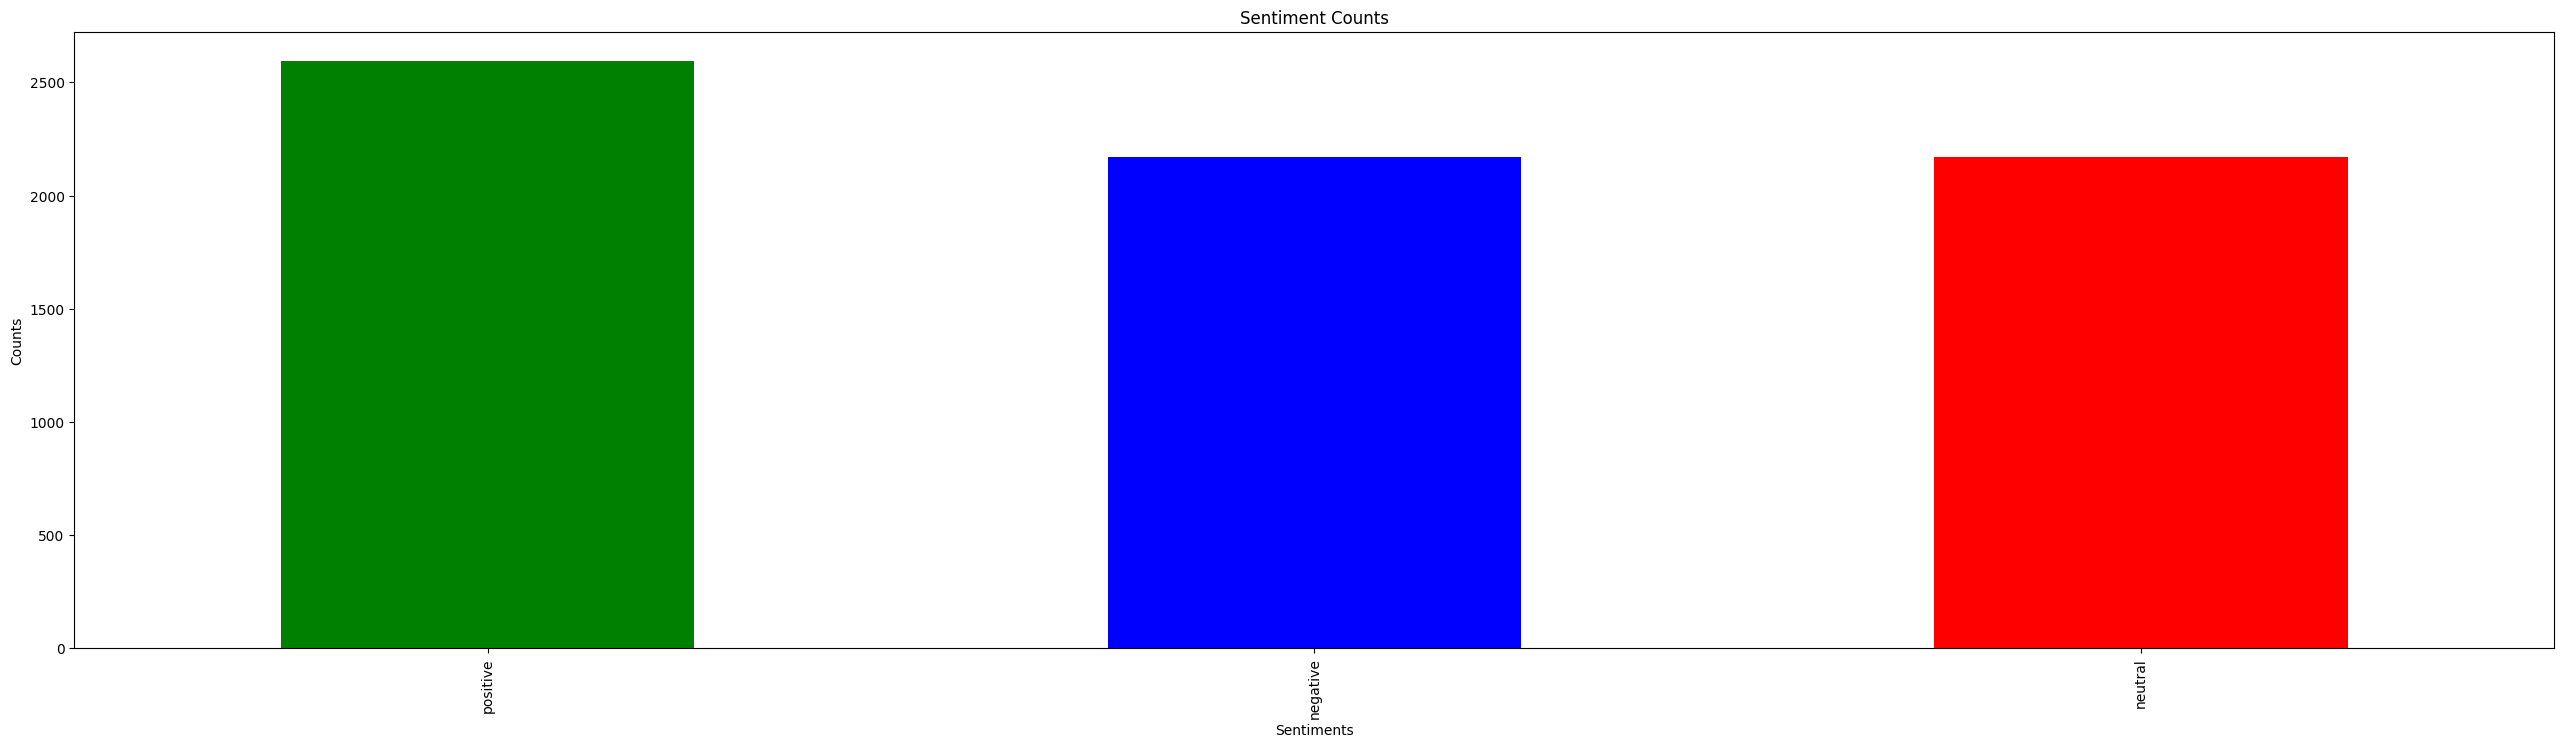

time: 610 ms (started: 2024-06-21 13:43:37 +00:00)


In [ ]:
df_text.sentiment.value_counts().plot.bar(x="Sentiments", y="Texts", figsize=(32, 8), color=['green', 'blue', 'red'])

plt.title('Sentiment Counts')
plt.xlabel('Sentiments')
plt.ylabel('Counts')

plt.show()

The dataset is **balanced (more or less)**: the number of samples are almost evenly distrubuted over the sentiments.

The dataset is too small and we need to **augment** it.

## Analyze News (Text)

### Calculate the number of words in each reviews

In [ ]:
df_text['words'] = df_text['text'].apply(lambda x: len(word_tokenize(x)))

time: 8.55 s (started: 2024-06-21 13:43:38 +00:00)


In [ ]:
df_text.tail()

,text,sentiment,words
6930,Польша запустила запрет Европейского Союза на ...,neutral,31
6931,В 2022 году Китай тщательно контролировал санк...,negative,33
6932,Немецкий производитель нефти и газа Wintershal...,neutral,27
6933,Российский энергетический гигант Роснефт объяв...,positive,32
6934,Индия отказывается от долларов на торговлю неф...,positive,13


time: 28.1 ms (started: 2024-06-21 13:43:46 +00:00)


### Review Length in terms of Number of Words

In [ ]:
df_text['words'].describe()

count    6935.000000
mean       40.967412
std        27.173944
min         2.000000
25%        23.000000
50%        33.000000
75%        51.000000
max       281.000000
Name: words, dtype: float64

time: 31.7 ms (started: 2024-06-21 13:43:46 +00:00)


### Review Length in terms of Number of Words per Topic

In [ ]:
df_text.groupby(['sentiment'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,2171.0,41.203593,28.440527,6.0,22.0,32.0,52.0,231.0
neutral,2170.0,39.125346,25.903266,2.0,23.0,32.0,46.0,281.0
positive,2594.0,42.310717,27.051205,2.0,23.0,35.0,53.0,279.0


time: 147 ms (started: 2024-06-21 13:43:47 +00:00)


### Number of short reviews

We can check the number of short reviews by comparing a threshold:

In [ ]:
min_review_size = 9
df_text[df_text['words']>min_review_size].count()

text         6848
sentiment    6848
words        6848
dtype: int64

time: 20.9 ms (started: 2024-06-21 13:43:47 +00:00)


Let's see some short review samples:

In [ ]:
df_text[df_text['words']<min_review_size]

,text,sentiment,words
18,Турция не будет вводить санкции против России.,positive,8
590,Военные заключенные Анхеузера-Буша в Украине-Б...,neutral,6
601,Тюркие не будет налагать санкции против России.,positive,8
680,Упира Karelia предоставит Азию на рынок.,positive,7
962,Разрыв американского производителя одежды не п...,positive,8
967,Индонезия готовится отвергнуть Россию из России.,negative,7
1068,Применить одобрение процесса имущества OPEC в ...,neutral,8
1124,"Ожидайте стран ""больших семи""",positive,6
1130,Решение Японии запретить наиболее используемые...,neutral,8
1185,Тюркие не наложил санкции против России.,positive,7


time: 45.9 ms (started: 2024-06-21 13:43:47 +00:00)


###  Decide minimum and maximum review size

**Important:** In some tasks, we can assume that **short** reviews can not convey **necessary /enough information** for training and testin a ML model. For example, in **Text Generation**, if you would like to generate longer text, you would prefer training your model with **longer** text examples.


As a results, according to the ML task at hand, you can use the above statistics, to set up a **minimum** and **maximum** review size in terms of words.

Here, I set these parameters as follows:

### for DL Conv1D

In [ ]:
min_review_size = 10
max_review_size = 60

time: 557 µs (started: 2024-06-21 13:43:47 +00:00)


In [ ]:
df_text.count()

text         6935
sentiment    6935
words        6935
dtype: int64

time: 18.1 ms (started: 2024-06-21 13:43:47 +00:00)


In [ ]:
data = df_text[df_text['words']>=min_review_size]

time: 9.43 ms (started: 2024-06-21 13:43:47 +00:00)


In [ ]:
data[data['words']<min_review_size].count()

text         0
sentiment    0
words        0
dtype: int64

time: 11.4 ms (started: 2024-06-21 13:43:47 +00:00)


## Analyze the Vocabulary



### Count the distinct words

Let's look into the **raw** dataset to count the **distinct words**

In [ ]:
vocab = {word.lower() for sentence in [x.split() for x in data['text'].tolist()] for word in sentence}
print("Number of distinct words in raw data:", len(vocab))

Number of distinct words in raw data: 29607
time: 478 ms (started: 2024-06-21 13:43:47 +00:00)


In [ ]:
vocab_size = len(vocab)

time: 505 µs (started: 2024-06-21 13:43:47 +00:00)


### Count the frequency of words in the raw dataset

In [ ]:
word_freq = (
    data.text.str.split(expand=True)
    .stack()
    .value_counts()
    .reset_index(name='freq')
    .rename(columns={'index': 'word'})
)

time: 1.33 s (started: 2024-06-21 13:43:47 +00:00)


Let's check the **top 50** words:

In [ ]:
top_50_frequent_words = word_freq[:50]
top_50_frequent_words

,word,freq
0,в,11730
1,и,7912
2,на,4277
3,с,3196
4,из,2430
5,что,2424
6,для,1951
7,России,1611
8,по,1354
9,против,1353


time: 30.5 ms (started: 2024-06-21 13:43:49 +00:00)


Let's see which **top-50** frequent words are in the **stop-word** list that we loaded at the beginning:

In [ ]:
count = 0
for each in top_50_frequent_words['word']:
  if each in ru_stop_words.values:
    count += 1
    print(each)

в
и
на
с
из
что
для
по
против
не
к
от
года
которые
как
за
до
чтобы
о
после
также
а
более
были
который
time: 22.6 ms (started: 2024-06-21 13:43:49 +00:00)


In [ ]:
print(f"Almost {count} words out of the top-50 words are stop words. Therefore, during preprocessing, we could take care of the stop-words.")

Almost 25 words out of the top-50 words are stop words. Therefore, during preprocessing, we could take care of the stop-words.
time: 574 µs (started: 2024-06-21 13:43:49 +00:00)


In [ ]:
b=

# PREPARE THE DATASET

## Convert Sentiments From Strings to Integer Ids

In [ ]:
data["sentiment"] = data["sentiment"].astype('category')
data.dtypes

<ipython-input-47-ffc60330e913>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment"] = data["sentiment"].astype('category')


text           object
sentiment    category
words           int64
dtype: object

time: 27.4 ms (started: 2024-06-21 13:43:49 +00:00)


In [ ]:
df_val["sentiment"] = df_val["sentiment"].astype('category')
df_val.dtypes

title          object
sentiment    category
dtype: object

time: 23.9 ms (started: 2024-06-21 13:43:49 +00:00)


In [ ]:
data["sentiment_id"] = data["sentiment"].cat.codes
data.tail()

<ipython-input-49-7af1486dc411>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment_id"] = data["sentiment"].cat.codes


,text,sentiment,words,sentiment_id
6930,Польша запустила запрет Европейского Союза на ...,neutral,31,1
6931,В 2022 году Китай тщательно контролировал санк...,negative,33,0
6932,Немецкий производитель нефти и газа Wintershal...,neutral,27,1
6933,Российский энергетический гигант Роснефт объяв...,positive,32,2
6934,Индия отказывается от долларов на торговлю неф...,positive,13,2


time: 17.8 ms (started: 2024-06-21 13:44:18 +00:00)


In [ ]:
df_val["sentiment_id"] = df_val["sentiment"].cat.codes
df_val.tail()

,title,sentiment,sentiment_id
481,Минсельхоз предлагает не ограничивать список т...,negative,0
482,Суд Лондона обязал норвежскую судоходную компа...,negative,0
483,В условиях санкционного давления наблюдается р...,positive,2
484,Американский производитель одежды Gap не ушел ...,neutral,1
485,Координатор стратегических коммуникаций в Сове...,neutral,1


time: 17.3 ms (started: 2024-06-21 13:44:18 +00:00)


## Build a Dictionary for id to text sentiments:

In [ ]:
id_to_sentiment = pd.Series(data.sentiment.values,index=data.sentiment_id).to_dict()
id_to_sentiment

{0: 'negative', 2: 'positive', 1: 'neutral'}

time: 15.5 ms (started: 2024-06-21 13:44:19 +00:00)


## Build another Dictionary for sentiments to text:

In [ ]:
sentiment_to_id = {v:k for k,v in id_to_sentiment.items()}
sentiment_to_id

{'negative': 0, 'positive': 2, 'neutral': 1}

time: 5.63 ms (started: 2024-06-21 13:44:19 +00:00)


### Check the conversions:

In [ ]:
%cd "__seminary_practice"
!ls

[Errno 2] No such file or directory: '__seminary_practice'
/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/__seminary_practice
 00_eda.ipynb				      SentiWordNet_3.0.0.txt
 augmented_full_sentiment_16_x_english.xlsx   stop_words_english.txt
 augmented_full_sentiment_16_x.xlsx	      stopwords-ru.txt
'How to solve the task.gdoc'		      sums_lang_for_news.xlsx
 id_to_sentiment.pkl			      text_classifiaction_using_lora.ipynb
 logs					      text-classification-using-lora.ipynb
 lora_bert_model			     'text-classification-using-lora_latest (1).ipynb'
 lora_models				      text-classification-using-lora_latest.ipynb
 model.png				     'Text Classification with Deep Learning Models.ipynb'
 models					      texts_for_news.xlsx
 MultiClassTextClassification_Conv1D	      upgraded_lora.ipynb
 MultiClassTextClassification_FFN	      vectorize_layer_model
 optimized_lora_distilbert_model_quantized   'Позитивные-негативные англ (1).docx'
 Otchet					      санкции_full_20240416.xlsx
 results	

In [ ]:
import pickle
with open('id_to_sentiment.pkl', 'wb') as fp:
    pickle.dump(id_to_sentiment, fp)

time: 314 ms (started: 2024-06-21 13:44:20 +00:00)


In [ ]:
with open('id_to_sentiment.pkl', 'rb') as fp:
    id_to_sentiment_loaded = pickle.load(fp)

time: 13.9 ms (started: 2024-06-21 13:44:20 +00:00)


In [ ]:
id_to_sentiment_loaded

{0: 'negative', 2: 'positive', 1: 'neutral'}

time: 3.7 ms (started: 2024-06-21 13:44:20 +00:00)


In [ ]:
number_of_sentiment = len(sentiment_to_id)
print(f"number of sentiments: {number_of_sentiment}")

number of sentiments: 3
time: 718 µs (started: 2024-06-21 13:44:20 +00:00)


## Split the Raw Dataset into Train, Validation, and Test Datasets


### Split Train & Test Datasets

In [ ]:
data

,text,sentiment,words,sentiment_id
0,США в очередной раз ужесточили правила экспорт...,negative,136,0
1,"Санкции, введенные против России, такие как ис...",negative,92,0
2,Посол Бразилии в Организации Объединенных Наци...,negative,82,0
3,Беспрецедентные санкции против российских банк...,negative,81,0
4,Государственная энергетическая компания Индоне...,positive,41,2
...,...,...,...,...
6930,Польша запустила запрет Европейского Союза на ...,neutral,31,1
6931,В 2022 году Китай тщательно контролировал санк...,negative,33,0
6932,Немецкий производитель нефти и газа Wintershal...,neutral,27,1
6933,Российский энергетический гигант Роснефт объяв...,positive,32,2


time: 57.7 ms (started: 2024-06-21 13:44:22 +00:00)


In [ ]:
train_val_dataset

,text,sentiment,words,sentiment_id
2275,В то время как серия санкций привела к колебан...,positive,23,2
1095,Испания и Франция уполномочили владельцев супе...,neutral,15,1
184,РФ и Бразилия продолжают обсуждение целого ряд...,positive,44,2
2853,Министр финансов Турции сказал предпринимателя...,neutral,35,1
5578,Министерство финансов США заместитель финансов...,neutral,30,1
...,...,...,...,...
1581,"Объединенные арабские эмираты, учитывая возмож...",negative,38,0
1804,Благодаря бесчисленным случаям отказа выполнит...,negative,33,0
5984,Внедрение сырой российской нефти в Германии сн...,negative,84,0
4933,Многие предприятия отказываются иметь дело с р...,positive,27,2


time: 145 ms (started: 2024-06-21 13:45:08 +00:00)


In [ ]:
train_val_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=23052024)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.1, random_state=23052024)

train_features = train_dataset['text']
train_target = train_dataset['sentiment_id']

val_features = val_dataset['text']
val_target = val_dataset['sentiment_id']

test_features = test_dataset['text']
test_target = test_dataset['sentiment_id']

time: 22 ms (started: 2024-06-21 13:45:24 +00:00)


In [ ]:
print("Train Data Set size: ", len(train_features))
print("Validation Data Set size: ", len(val_features))
print("Test Data Set size: ", len(test_features))

Train Data Set size:  4930
Validation Data Set size:  548
Test Data Set size:  1370
time: 2.72 ms (started: 2024-06-21 13:45:26 +00:00)


# PREPROCESSING TEXT WITH TF DATA PIPELINE AND KERAS TEXT VECTORIZATION LAYER

## Build the Train TensorFlow Datasets



We will create 2 **TF Datasets** from the **raw** Train Dataframe for further processing:
1. for input (text)
2. for target (sentiments)

In [ ]:
same_elements = train_features.equals(val_features)

print('Same elements:', same_elements)

Same elements: False
time: 802 µs (started: 2024-06-21 13:45:30 +00:00)


In [ ]:
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_features.values, tf.string)
)

time: 38.9 ms (started: 2024-06-21 13:45:31 +00:00)


In [ ]:
train_sentiment_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_target.values, tf.int64),
)

time: 13.3 ms (started: 2024-06-21 13:45:31 +00:00)


In [ ]:
train_text_ds_raw.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

time: 6.68 ms (started: 2024-06-21 13:45:31 +00:00)


In [ ]:
data.describe()

,words,sentiment_id
count,6848.000000,6848.000000
mean,41.389457,1.056513
std,27.084682,0.826847
min,10.000000,0.000000
25%,23.000000,0.000000
50%,33.000000,1.000000
75%,51.000000,2.000000
max,281.000000,2.000000


time: 22.1 ms (started: 2024-06-21 13:45:31 +00:00)


## Decide the dictionary size and the review size

For preprocessing the text, we need to decide the **dictionary (vocab) size** and the **maximum review (text) size**.

We will just take the `min` and `max`.

In [ ]:
vocab_size = vocab_size
max_len = max_review_size

time: 823 µs (started: 2024-06-21 16:34:50 +00:00)


## Prepare the Keras Text Vectorization layer



### Custom Standardization
As a first step of text preprocessing, we will standardize the text by using the below function.

In [ ]:
@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    """ Preprocess Russian text """
    # Convert text to lowercase
    no_uppercased = tf.strings.lower(input_string, encoding='utf-8')
    # Remove HTML tags
    no_html_tags = tf.strings.regex_replace(no_uppercased, "<[^>]+>", " ")
    # Remove email addresses
    no_emails = tf.strings.regex_replace(no_html_tags, r'\S+@\S+', ' ')
    # Remove digits
    no_digits = tf.strings.regex_replace(no_emails, r"\d", " ")
    # Remove punctuation
    no_punctuations = tf.strings.regex_replace(no_digits, f"([{string.punctuation}])", r" ")
    # Remove newlines
    no_newlines = tf.strings.regex_replace(no_punctuations, "\n", " ")
    # Remove extra spaces
    no_extra_space = tf.strings.regex_replace(no_newlines, " +", " ")
    no_Ё = tf.strings.regex_replace(no_extra_space, "ё", "е")
    no_Й = tf.strings.regex_replace(no_Ё, "й", "и")
    return no_Й

time: 1.18 ms (started: 2024-06-21 13:45:32 +00:00)


In [ ]:
input_string = """
<html>
<head>
<title>Прймер -_=заголовка</title>
</head>
<body>
<p>Это пример текста с некоторыми знаками пунктуации: тест, тест, тест.</p>
<p>Также в нем содержатся цифры, напримёр 123456.</p>
<p>И некоторые образцы - _ для удаления: образец1 и образец2.</p>
<p>Контактный адрес электронной почты: example@example.com</p>
</body>
</html>
"""

print("input:  ", input_string)
output_string= custom_standardization(input_string)
print("output: ", output_string.numpy().decode("utf-8"))

input:   
<html>
<head>
<title>Прймер -_=заголовка</title>
</head>
<body>
<p>Это пример текста с некоторыми знаками пунктуации: тест, тест, тест.</p>
<p>Также в нем содержатся цифры, напримёр 123456.</p>
<p>И некоторые образцы - _ для удаления: образец1 и образец2.</p>
<p>Контактный адрес электронной почты: example@example.com</p>
</body>
</html>

output:   пример заголовка это пример текста с некоторыми знаками пунктуации тест тест тест также в нем содержатся цифры например и некоторые образцы для удаления образец и образец контактныи адрес электроннои почты 
time: 20.8 ms (started: 2024-06-21 13:45:32 +00:00)


### Build a TextVectorization layer

Let's build our `TextVectorization` layer:

In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=max_len,
)

time: 23.1 ms (started: 2024-06-21 13:45:33 +00:00)


### Adopt the Text Vectorization layer

In [ ]:
vectorize_layer.adapt(train_text_ds_raw)
vocab = vectorize_layer.get_vocabulary()

time: 10.5 s (started: 2024-06-21 13:45:33 +00:00)


### Check the dictionary (vocab) and preprocessing

In [ ]:
# Print the number of entries in the vocabulary
print("vocab has the ", len(vocab)," entries")

# Print the first 10 entries in the vocabulary
print("vocab has the following first 10 entries")
for word in range(10):
  print(word, " represents the word: ", vocab[word])

# Print a header indicating that the following code will preprocess 2 text samples
print("2 sample text preprocessing:")

# Loop over 2 random samples from the train_text_ds_raw dataset
for X in train_text_ds_raw.take(2):

  # Print the raw text data for the current sample
  print(" Given raw data: " )
  print(X.numpy().decode("utf-8") )

  # Tokenize the raw text data using the TextVectorization layer and convert the tokens to a vector of integers
  tokenized = vectorize_layer(tf.expand_dims(X, -1))

  # Print the tokenized and transformed text data as a vector of integers
  print(" Tokenized and Transformed to a vector of integers: " )
  print (tokenized)

  # Convert the vector of integers back to a string of words by looking up each integer in the vocabulary
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ vocab[each]
  print(" Text after Tokenized and Transformed: ")
  print(transformed)

vocab has the  19507  entries
vocab has the following first 10 entries
0  represents the word:  
1  represents the word:  [UNK]
2  represents the word:  в
3  represents the word:  и
4  represents the word:  на
5  represents the word:  с
6  represents the word:  россии
7  represents the word:  из
8  represents the word:  санкции
9  represents the word:  что
2 sample text preprocessing:
 Given raw data: 
В первой половине 2023 года Виола (бывшее имя Валио), бывшая «дочь» финского Валио, которая покинула Россию, продала почти 6,5 тысяч тонн продуктов, что на 26% больше, чем за тот же период 2022 года. Из компании поставляется не только по всей России, но и в близлежащие страны за рубежом и во Вьетнаме.
 Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[    2   492   597    11  3051  4838  2654  1693  3061  3087  3657  1693
     52  2568    34  2857   175   193    58    51     9     4   143    79
     12  1192   138   354    11     7    17  3302    16   129    13  2173
     

### Save & Load the adopted TextVectorization layer
Since adopting `TextVectorization` layer may take **considerable time**, you would like to save it for future runs.
As a simple and straight way, we can save the trained `TextVectorization` layer by embedding in a Keras model as follows:

In [ ]:
vectorizer_model = tf.keras.models.Sequential()
vectorizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorizer_model.add(vectorize_layer)
vectorizer_model.summary()

filepath = "vectorize_layer_model"
vectorizer_model.save(filepath, save_format="tf")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 60)                0         
 ctorization)                                                    
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


time: 2 s (started: 2024-06-21 13:45:44 +00:00)


In [ ]:
# Load the saved model
loaded_vectorizer_model = tf.keras.models.load_model(filepath)
loaded_vectorizer_layer = loaded_vectorizer_model.layers[0]

time: 342 ms (started: 2024-06-21 13:45:46 +00:00)


### Check the loaded Text Vectorization layer

We have 2 options:
* Use the loaded model to vectorize the text, or
* Use the loaded layer.

Let's check if the loaded model and the layer have the same **vocab** and **preprocessing behaivor**.

In [ ]:
loaded_vocab = loaded_vectorizer_layer.get_vocabulary()
print("original vocab has the ", len(vocab)," entries")
print("loaded_vectorizer_layer vocab has the ", len(loaded_vocab)," entries")
print("original vocab: ", vocab[:10])
print("loaded vocab  : ", loaded_vocab[:10])

original vocab has the  19507  entries
loaded_vectorizer_layer vocab has the  19507  entries
original vocab:  ['', '[UNK]', 'в', 'и', 'на', 'с', 'россии', 'из', 'санкции', 'что']
loaded vocab  :  ['', '[UNK]', 'в', 'и', 'на', 'с', 'россии', 'из', 'санкции', 'что']
time: 87.9 ms (started: 2024-06-21 13:45:47 +00:00)


In [ ]:
for X in train_text_ds_raw.take(1):
  print(" Given raw data: " )
  print(X.numpy().decode("utf-8") )

  tokenized = vectorize_layer(tf.expand_dims(X, -1))
  print(" original vectorizer layer: Tokenized and Transformed to a vector of integers: " )
  print(tokenized)

  tokenized = loaded_vectorizer_layer(tf.expand_dims(X, -1))
  print(" loaded_vectorizer_layer: Tokenized and Transformed to a vector of integers: " )
  #print (tokenized.to_tensor(shape=[1, max_review_size]))
  print(tokenized)

  tokenized = loaded_vectorizer_model.predict(tf.expand_dims(X, -1))
  print(" loaded_vectorizer_model: Tokenized and Transformed to a vector of integers: " )
  #print (tokenized.to_tensor(shape=[1, max_review_size]))
  print(tokenized)

  print(" Text after Tokenized and Transformed: ")
  transformed = ""
  for each in tf.squeeze(tokenized):
    transformed= transformed+ " "+ vocab[each]
  print(transformed)

 Given raw data: 
В первой половине 2023 года Виола (бывшее имя Валио), бывшая «дочь» финского Валио, которая покинула Россию, продала почти 6,5 тысяч тонн продуктов, что на 26% больше, чем за тот же период 2022 года. Из компании поставляется не только по всей России, но и в близлежащие страны за рубежом и во Вьетнаме.
 original vectorizer layer: Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[    2   492   597    11  3051  4838  2654  1693  3061  3087  3657  1693
     52  2568    34  2857   175   193    58    51     9     4   143    79
     12  1192   138   354    11     7    17  3302    16   129    13  2173
      6    65     3     2 17388    25    12   855     3    94  2403     0
      0     0     0     0     0     0     0     0     0     0     0     0]], shape=(1, 60), dtype=int64)
 loaded_vectorizer_layer: Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[    2   492   597    11  3051  4838  2654  1693  3061  3087  3657  1693
     52  2568    34  285

## Preprocess the Train & Test Data by the adopted TextVecorization Layer

In [ ]:
prepare_lm_inputs_labels = lambda text: tf.squeeze(vectorize_layer(tf.expand_dims(text, -1)))

time: 672 µs (started: 2024-06-21 13:45:47 +00:00)


### Process the Train Data

In [ ]:
train_text_ds = train_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

time: 73.5 ms (started: 2024-06-21 13:45:47 +00:00)


**Let's check the result**

In [ ]:
train_text_ds.element_spec

TensorSpec(shape=<unknown>, dtype=tf.int64, name=None)

time: 4.55 ms (started: 2024-06-21 13:45:47 +00:00)


In [ ]:
train_ds = tf.data.Dataset.zip(
    (train_text_ds,train_sentiment_ds_raw)
)

time: 4.3 ms (started: 2024-06-21 13:45:47 +00:00)


In [ ]:
train_size = train_ds.cardinality().numpy()
print("Train size: ", train_size)

Train size:  4930
time: 1.26 ms (started: 2024-06-21 13:45:47 +00:00)


### Process the Validation Data

Let's create the input (text) and output TF Datasets:

In [ ]:
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(val_features.values, tf.string)
)

time: 5.04 ms (started: 2024-06-21 13:45:47 +00:00)


In [ ]:
val_sentiment_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(val_target.values, tf.int64),
)

time: 4.79 ms (started: 2024-06-21 13:45:48 +00:00)


Let's apply the same fuction ```prepare_lm_inputs_labels``` for the text in the validation data as follows:

In [ ]:
val_text_ds = val_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

time: 72.5 ms (started: 2024-06-21 13:45:54 +00:00)


We can now create the validation dataset by putting together the input (tokenized text) and the expected output as follows:

In [ ]:
val_ds = tf.data.Dataset.zip(
    (val_text_ds, val_sentiment_ds_raw)
)

time: 3.57 ms (started: 2024-06-21 13:45:54 +00:00)


### Process the Test Data

In [ ]:
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_features.values, tf.string)
)

time: 8.51 ms (started: 2024-06-21 13:45:56 +00:00)


In [ ]:
test_sentiment_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_target.values, tf.int64),
)

time: 4 ms (started: 2024-06-21 13:45:56 +00:00)


In [ ]:
test_text_ds = test_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

time: 58.2 ms (started: 2024-06-21 13:45:56 +00:00)


We can now create the test dataset by putting together the input (tokenized reviews) and the expected output (the topic/class id) as follows:

In [ ]:
test_ds = tf.data.Dataset.zip(
    (test_text_ds, test_sentiment_ds_raw)
)

time: 6.41 ms (started: 2024-06-21 13:45:57 +00:00)


In [ ]:
test_size = test_ds.cardinality().numpy()
print("Test size: ", test_size)

Test size:  1370
time: 2.39 ms (started: 2024-06-21 13:45:58 +00:00)


## Finalize the TensorFlow Data Pipeline

We can now configure and optimize the train, validation, and test datasets.

In [ ]:
batch_size=64
AUTOTUNE=tf.data.experimental.AUTOTUNE

train_ds=train_ds.shuffle(buffer_size=train_size)
train_ds=train_ds.batch(batch_size=batch_size,drop_remainder=True)
train_ds=train_ds.cache()
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds=val_ds.shuffle(buffer_size=train_size)
val_ds=val_ds.batch(batch_size=batch_size,drop_remainder=True)
val_ds=val_ds.cache()
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds=test_ds.shuffle(buffer_size=train_size)
test_ds=test_ds.batch(batch_size=batch_size,drop_remainder=True)
test_ds=test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

time: 28.4 ms (started: 2024-06-21 13:45:59 +00:00)


Notice that we have now batches of reviews and topics:

In [ ]:
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

time: 3.65 ms (started: 2024-06-21 13:46:01 +00:00)


# TEXT CLASSIFICATION WITH AN EMBEDDING LAYER IN A FEED FORWARD NETWORK

## Keras Embedding Layer

## A simple model with an embedding layer

In [ ]:
class FFNModel:
    def __init__(self, max_len, vocab_size, embed_dim=16, feed_forward_dim=64, number_of_sentiment=3):
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.feed_forward_dim = feed_forward_dim
        self.number_of_sentiment = number_of_sentiment

    def build_model(self):
        inputs_tokens = layers.Input(shape=(self.max_len,), dtype=tf.int32)
        embedding_layer = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embed_dim,
                                           input_length=self.max_len)
        x = embedding_layer(inputs_tokens)
        x = layers.Flatten()(x)
        dense_layer = layers.Dense(self.feed_forward_dim, activation='relu')
        x = dense_layer(x)
        x = layers.Dropout(.5)(x)
        outputs = layers.Dense(self.number_of_sentiment)(x)

        model = keras.Model(inputs=inputs_tokens, outputs=outputs, name='model_FFN')
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
        model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)

        return model

model_builder = FFNModel(max_len, vocab_size)
model_FFN = model_builder.build_model()

time: 121 ms (started: 2024-06-21 13:46:05 +00:00)


In [ ]:
model_FFN.summary()

Model: "model_FFN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 16)            473712    
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 64)                61504     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 535411 (2.04 MB)
Trainable params: 535411 (

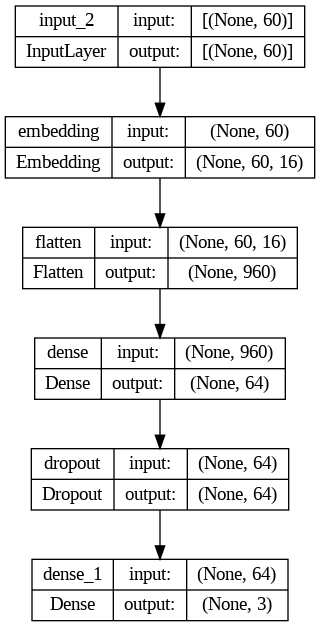

time: 413 ms (started: 2024-06-21 13:46:43 +00:00)


In [ ]:
tf.keras.utils.plot_model(model_FFN,show_shapes=True)

## Train

In [ ]:
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

time: 3.68 ms (started: 2024-06-21 13:46:45 +00:00)


In [ ]:
history = model_FFN.fit(train_ds, validation_data=val_ds, verbose=2, epochs=7)

Epoch 1/7
77/77 - 3s - loss: 1.0773 - sparse_categorical_accuracy: 0.4223 - val_loss: 1.0145 - val_sparse_categorical_accuracy: 0.6621 - 3s/epoch - 44ms/step
Epoch 2/7
77/77 - 1s - loss: 0.7426 - sparse_categorical_accuracy: 0.7877 - val_loss: 0.4784 - val_sparse_categorical_accuracy: 0.8633 - 595ms/epoch - 8ms/step
Epoch 3/7
77/77 - 1s - loss: 0.2080 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.2416 - val_sparse_categorical_accuracy: 0.9238 - 572ms/epoch - 7ms/step
Epoch 4/7
77/77 - 1s - loss: 0.0504 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.2026 - val_sparse_categorical_accuracy: 0.9277 - 584ms/epoch - 8ms/step
Epoch 5/7
77/77 - 1s - loss: 0.0220 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.1944 - val_sparse_categorical_accuracy: 0.9316 - 555ms/epoch - 7ms/step
Epoch 6/7
77/77 - 1s - loss: 0.0119 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.1819 - val_sparse_categorical_accuracy: 0.9355 - 546ms/epoch - 7ms/step
Epoch 7/7
77/77 - 1s - loss: 0.0081 - spar

Let's observe the **accuracy** and the **loss** values during the training at each epoch:

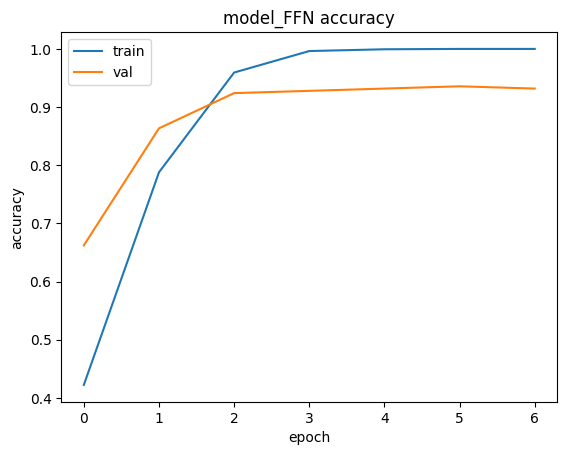

time: 500 ms (started: 2024-06-21 13:47:26 +00:00)


In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model_FFN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

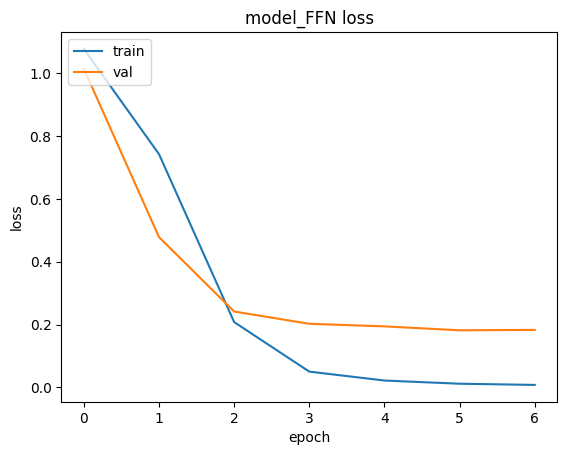

time: 258 ms (started: 2024-06-21 13:47:29 +00:00)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_FFN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Save the trained model

In [ ]:
tf.keras.models.save_model(model_FFN, 'MultiClassTextClassification_FFN')

time: 1.66 s (started: 2024-06-21 13:47:30 +00:00)


## Test

We can test the trained model with the test dataset:

In [ ]:
loss, accuracy = model_FFN.evaluate(test_ds)
print("Test accuracy: ", accuracy)

21/21 [==============================] - 0s 4ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9271
Test accuracy:  0.9270833134651184
time: 664 ms (started: 2024-06-21 13:47:40 +00:00)


## Predictions

We can use the **trained model** `predict()` method to **predict** the class of the given reviews as follows:

In [ ]:
preds = model_FFN.predict(test_ds)
preds = preds.argmax(axis=1)

21/21 [==============================] - 0s 2ms/step
time: 126 ms (started: 2024-06-21 13:47:46 +00:00)


We can also get the **actual (true)** class of the given reviews as follows:

In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

time: 339 ms (started: 2024-06-21 13:47:51 +00:00)


By comparing the ***`preds`*** and the ***`actuals`*** values, we can **measure** the model performance as below.

## Classification Report

Since we are dealing with a **classification**, it is a good idea to generate a **classification report** to observe the performance of the model for ***each class***. We can use the [SKLearn `classification_report()` method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to build a text report showing the main classification **metrics**.

Report is the summary of the **precision, recall, F1** score for ***each class***.

The reported ***averages*** include:
* **macro average** (averaging the unweighted mean per label),
* **weighted average** (averaging the support-weighted mean per label),  
* **sample average** (only for multilabel classification),
* **micro average** (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics.

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9416    0.9171    0.9292       422
           1     0.9603    0.9093    0.9341       452
           2     0.8871    0.9532    0.9190       470

    accuracy                         0.9271      1344
   macro avg     0.9297    0.9265    0.9274      1344
weighted avg     0.9288    0.9271    0.9273      1344

time: 15.4 ms (started: 2024-06-21 13:48:00 +00:00)


## Confusion Matrix

**Confusion Matrix** is used to know the performance of a Machine learning model at classification. The results are presented in a ***matrix*** form. Confusion Matrix gives a comparison between **Actual** and **Predicted** values. The numbers on the **diagonal** are the number of the **correct predictions**.

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_sentiment.values() ,columns = id_to_sentiment.values())

time: 6.63 ms (started: 2024-06-21 14:01:43 +00:00)


Below, you can observe the distribution of predictions over the classes.

In [ ]:
cm_df

,negative,positive,neutral
negative,387,6,29
positive,13,411,28
neutral,11,11,448


time: 27.7 ms (started: 2024-06-21 14:01:44 +00:00)


In [ ]:
%%capture
!pip install ipywidgets

time: 6.84 s (started: 2024-06-21 14:01:45 +00:00)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.update_heatmap(vmin, vmax)>

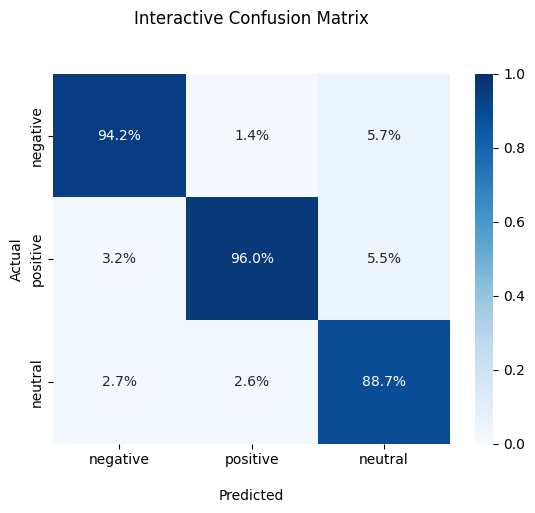

time: 344 ms (started: 2024-06-21 14:01:51 +00:00)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

def update_heatmap(vmin, vmax):
    ax = sns.heatmap(cm_df / np.sum(cm_df), vmin=vmin, vmax=vmax, annot=True, fmt='.1%', cmap='Blues')
    ax.set_title('Interactive Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(id_to_sentiment.values())
    ax.yaxis.set_ticklabels(id_to_sentiment.values())

interact(update_heatmap, vmin=fixed(0), vmax=fixed(1))

From this analysis, we can derive several insights:

1. The model performs reasonably well for all classes, with a relatively high number of correct classifications compared to misclassifications.

2. The model seems to struggle more with the Positive class, as it has a higher number of misclassifications compared to the other classes.

3. The Neutral class has the highest number of correctly classified instances, indicating that the model performs well for this class.

4. The model has relatively balanced performance across all classes, as there is no significant imbalance in the number of instances for each class.

Overall, based on this analysis, the model appears to be performing adequately across all classes, with some room for improvement, particularly for the Positive class.

# TEXT CLASSIFICATION WITH A CONVOLUTIONAL (CONV1D) LAYER

## Let's build a model with a Conv1D layer

In Keras, the Conv1D layer is defined as follows:

```python
tf.keras.layers.Conv1D(
    filters,
    kernel_size,
    padding="valid",
    activation=None
)
```

Here's what each parameter signifies:

- **filters**: This parameter denotes the number of output filters in the convolution, essentially representing the dimensionality of the output space.

- **kernel_size**: It specifies the length of the 1D convolution window. This can be provided as an integer or a tuple/list containing a single integer.

- **padding**: It determines how the input data should be padded before applying the convolution operation. The options include "valid" (no padding), "same" (padding with zeros evenly to maintain the input dimension), or "causal" (resulting in causal convolutions, useful for temporal data where the model should maintain temporal order).

- **activation**: This parameter denotes the activation function to be applied after the convolution operation. If left unspecified, no activation will be applied.

For the Conv1D layers in our model, we'll configure them as follows:

- For each Conv1D layer, we'll set the number of filters: 256 for the first layer and 128 for both the second and last layers.

- The kernel size will vary for each layer: 7 for the first layer, 5 for the second layer, and 3 for the last layer, allowing each to capture different patterns in the input data.

- We'll use "same" padding to ensure the output tensor retains the same dimensions as the input vector after convolution.

- For activation, we'll employ the 'relu' function, a common choice for intermediate layers in neural networks.

In [ ]:
from tensorflow.keras import layers, Model

class Conv1DModel:
    def __init__(self, vocab_size, max_len, number_of_categories):
        self.embed_dim = 16
        self.feed_forward_dim = 64
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.number_of_categories = number_of_categories

    def create_model(self):
        inputs_tokens = layers.Input(shape=(self.max_len,), dtype=tf.int32)
        embedding_layer = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embed_dim,
                                           input_length=self.max_len)
        x = embedding_layer(inputs_tokens)
        x = layers.Conv1D(filters=256, kernel_size=7,
                          padding='same', activation='relu')(x)
        x = layers.Conv1D(filters=128, kernel_size=5,
                          padding='same', activation='relu')(x)
        x = layers.Conv1D(filters=128, kernel_size=3,
                          padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(self.feed_forward_dim, activation='sigmoid')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.number_of_categories)(x)
        model = Model(inputs=inputs_tokens,
                      outputs=outputs, name='model_Conv1D')
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
        model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)
        return model


conv1d_model = Conv1DModel(vocab_size, max_len, 3)
model = conv1d_model.create_model()

time: 440 ms (started: 2024-06-21 14:01:55 +00:00)


In [ ]:
model.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 60, 16)            473712    
                                                                 
 conv1d (Conv1D)             (None, 60, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 128)           0         
 D)                                                              
                                                      

In [ ]:
model.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 60, 16)            473712    
                                                                 
 conv1d (Conv1D)             (None, 60, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 128)           0         
 D)                                                              
                                                      

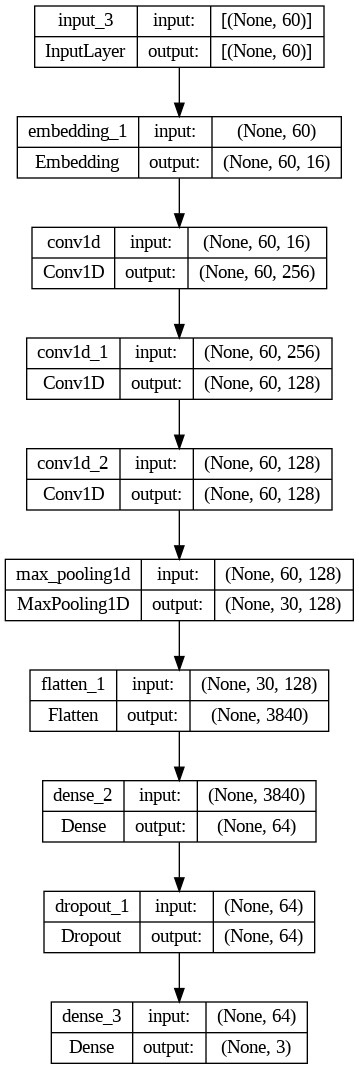

time: 357 ms (started: 2024-06-21 14:01:58 +00:00)


In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

## Train

In [ ]:
history=model.fit(train_ds, validation_data=val_ds ,verbose=1, epochs=25)

Epoch 1/25
77/77 [==============================] - 33s 374ms/step - loss: 1.1269 - sparse_categorical_accuracy: 0.4040 - val_loss: 0.8674 - val_sparse_categorical_accuracy: 0.5938
Epoch 2/25
77/77 [==============================] - 24s 312ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.6030 - val_sparse_categorical_accuracy: 0.7754
Epoch 3/25
77/77 [==============================] - 14s 181ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8902 - val_loss: 0.6265 - val_sparse_categorical_accuracy: 0.7969
Epoch 4/25
77/77 [==============================] - 14s 179ms/step - loss: 0.2473 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.6089 - val_sparse_categorical_accuracy: 0.8105
Epoch 5/25
77/77 [==============================] - 14s 179ms/step - loss: 0.1588 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.8223
Epoch 6/25
77/77 [==============================] - 15s 198ms/step - loss: 0.1042 - sparse_cate

Let's observe the **accuracy** and the **loss** values during the training:

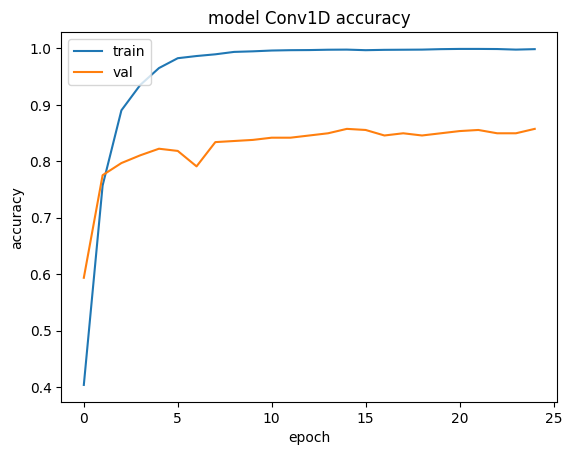

time: 1.24 s (started: 2024-06-21 14:10:17 +00:00)


In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model Conv1D accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

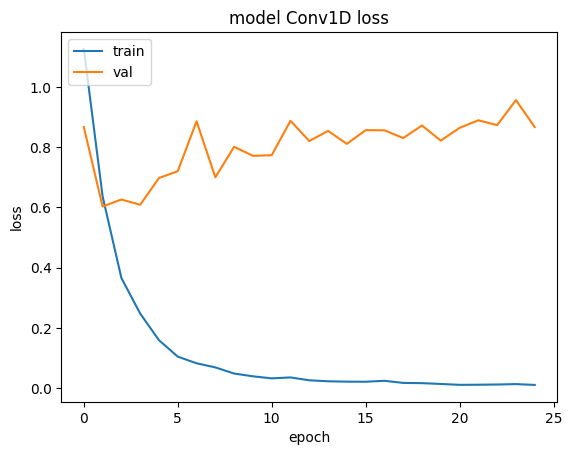

time: 552 ms (started: 2024-06-21 14:10:18 +00:00)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Conv1D loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Save the trained model

In [ ]:
tf.keras.models.save_model(model, 'MultiClassTextClassification_Conv1D')

time: 4.41 s (started: 2024-06-21 14:10:19 +00:00)


In [ ]:
model_Conv1D=tf.keras.models.load_model('MultiClassTextClassification_Conv1D')

time: 1.45 s (started: 2024-06-21 14:10:23 +00:00)


In [ ]:
model_Conv1D.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 60, 16)            473712    
                                                                 
 conv1d (Conv1D)             (None, 60, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 60, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 128)           0         
 D)                                                              
                                                      

## Test

In [ ]:
loss, accuracy = model_Conv1D.evaluate(test_ds)
print("Test accuracy: ", accuracy)

21/21 [==============================] - 1s 52ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.8586
Test accuracy:  0.8586309552192688
time: 1.45 s (started: 2024-06-21 14:10:25 +00:00)


## Predictions

We can use the **trained model** `predict()` method to **predict** the class of the given reviews as follows:

In [ ]:
preds = model_Conv1D.predict(test_ds)
preds = preds.argmax(axis=1)

21/21 [==============================] - 1s 38ms/step
time: 912 ms (started: 2024-06-21 14:10:26 +00:00)


We can also get the **actual (true)** class of the given reviews as follows:

In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

time: 359 ms (started: 2024-06-21 14:10:27 +00:00)


By comparing the ***`preds`*** and the ***`actuals`***
values, we can **measure** the model performance as below.

## Classification Report

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9610    0.8175    0.8835       422
           1     0.9220    0.8363    0.8770       452
           2     0.7496    0.9170    0.8249       470

    accuracy                         0.8586      1344
   macro avg     0.8775    0.8569    0.8618      1344
weighted avg     0.8739    0.8586    0.8608      1344

time: 15.3 ms (started: 2024-06-21 14:10:27 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,
# which compares the y_test and y_pred
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_sentiment.values() ,
                     columns = id_to_sentiment.values())

time: 4.96 ms (started: 2024-06-21 14:10:28 +00:00)


In [ ]:
cm_df

,negative,positive,neutral
negative,345,4,73
positive,3,378,71
neutral,11,28,431


time: 35.8 ms (started: 2024-06-21 14:39:18 +00:00)


We can also visualize the confusion matrix as the **ratios** of the predictions over the classes. The ratios on the **diagonal** are the ratios of the **correct predictions**.

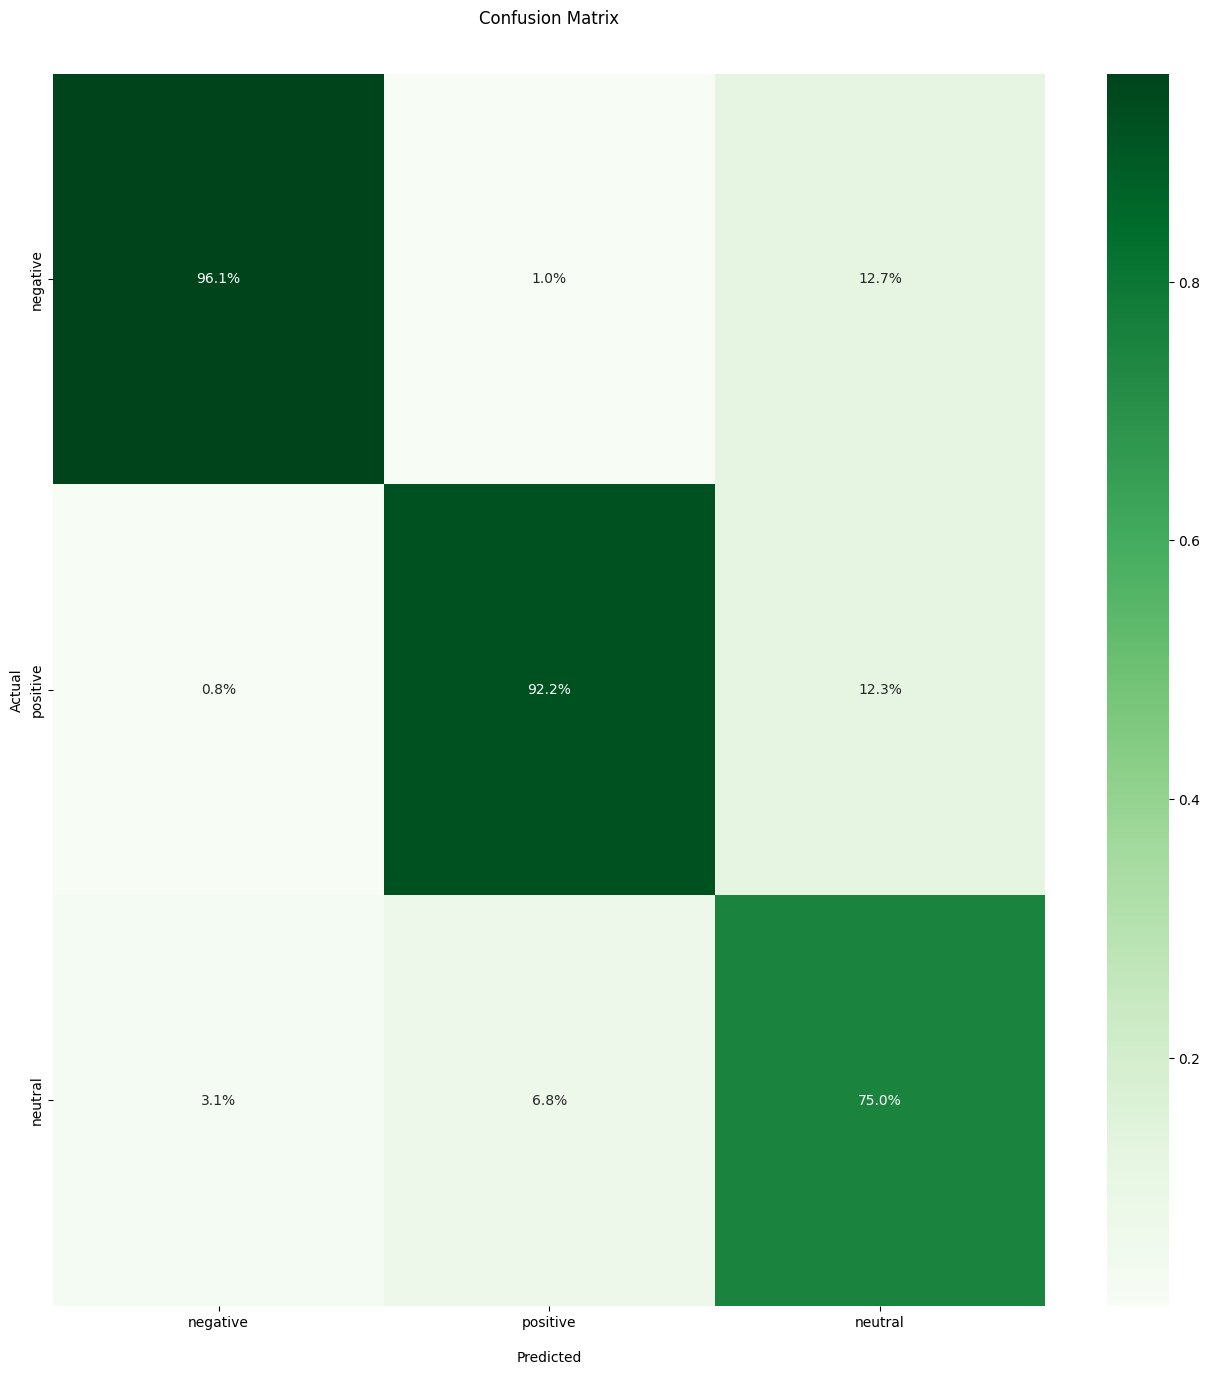

time: 379 ms (started: 2024-06-21 14:10:28 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
ax = sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.1%', cmap='Greens')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(id_to_sentiment.values())
ax.yaxis.set_ticklabels(id_to_sentiment.values())

plt.show()